In [8]:
# pip install pyreadr
import pandas as pd
import numpy as np
import pyreadr 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from linearmodels import PanelOLS #pip install linearmodels

In [9]:
# On April 1, 1992, New Jersey's minimum wage rose from $4.25 to $5.05 per hour. To evaluate the impact of the law, the authors surveyed 410 fast-food restaurants in New Jersey and eastern Pennsylvania before and after the rise.

# Does the rise in the minimum wage reduce employment?

In [10]:
result = pyreadr.read_r('/Users/mingzhangyin/Dropbox (UFL)/UF teaching/My course/12-Panel data methods- DiD, synthetic control/data/card.rds')
card_krueger_1994_mod = result[None] # the result is a dictionary containing the data frame(s), we get the first data frame with None
print(card_krueger_1994_mod.head())

  bonus   chain co_owned  date  empft  emppt  firstinc  hrsopen  inctime  \
0   yes      bk       no  None   30.0   15.0       NaN     16.5     19.0   
1    no     kfc       no  None    6.5    6.5       NaN     13.0     26.0   
2    no     kfc      yes  None    3.0    7.0      0.37     10.0     13.0   
3   yes  wendys      yes  None   20.0   20.0      0.10     12.0     26.0   
4   yes  wendys      yes  None    6.0   26.0      0.15     12.0     52.0   

                               meals  ...  psoda    region  sheet  special  \
0                reduced price meals  ...   1.03  phillypa   46.0      NaN   
1                reduced price meals  ...   1.01  phillypa   49.0      NaN   
2                reduced price meals  ...   0.95  phillypa  506.0      NaN   
3                reduced price meals  ...   0.87  phillypa   56.0      NaN   
4  both free and reduced price meals  ...   0.87  phillypa   61.0      NaN   

          state  status  type  wage_st  emptot    pct_fte  
0  Pennsylvani

In [11]:
card_krueger_1994_mod.shape

(820, 29)

In [12]:
card_krueger_1994_mod.columns

Index(['bonus', 'chain', 'co_owned', 'date', 'empft', 'emppt', 'firstinc',
       'hrsopen', 'inctime', 'meals', 'ncalls', 'nmgrs', 'nregs', 'nregs11',
       'observation', 'open', 'pctaff', 'pentree', 'pfry', 'psoda', 'region',
       'sheet', 'special', 'state', 'status', 'type', 'wage_st', 'emptot',
       'pct_fte'],
      dtype='object')

In [13]:
# Distribution of restaurants
prop = pd.crosstab(index=card_krueger_1994_mod['chain'], columns=card_krueger_1994_mod['state'], normalize='columns')
print(prop.applymap(lambda x: f'{x:.1%}').to_string())

state  New Jersey Pennsylvania
chain                         
bk          41.1%        44.3%
kfc         20.5%        15.2%
roys        24.8%        21.5%
wendys      13.6%        19.0%


In [14]:
# Pre-treatment means
pre_means = card_krueger_1994_mod.query("observation == 'February 1992'").groupby('state')\
                                     .agg({'emptot': 'mean', 'pct_fte': 'mean', 'wage_st': 'mean', 'hrsopen': 'mean'})\
                                     .reset_index()\
                                     .melt(id_vars='state', var_name='variable', value_name='value')\
                                     .pivot(index='variable', columns='state', values='value')
print(pre_means)

state     New Jersey  Pennsylvania
variable                          
emptot     20.439408     23.331169
hrsopen    14.418429     14.525316
pct_fte    32.848870     35.037798
wage_st     4.612134      4.630132


In [15]:
# Post-treatment means
post_means = card_krueger_1994_mod.query("observation == 'November 1992'").groupby('state')\
                                      .agg({'emptot': 'mean', 'pct_fte': 'mean', 'wage_st': 'mean', 'hrsopen': 'mean'})\
                                      .reset_index()\
                                      .melt(id_vars='state', var_name='variable', value_name='value')\
                                      .pivot(index='variable', columns='state', values='value')
print(post_means)

state     New Jersey  Pennsylvania
variable                          
emptot     21.027429     21.165584
hrsopen    14.419782     14.653846
pct_fte    35.865552     30.384849
wage_st     5.080849      4.617465


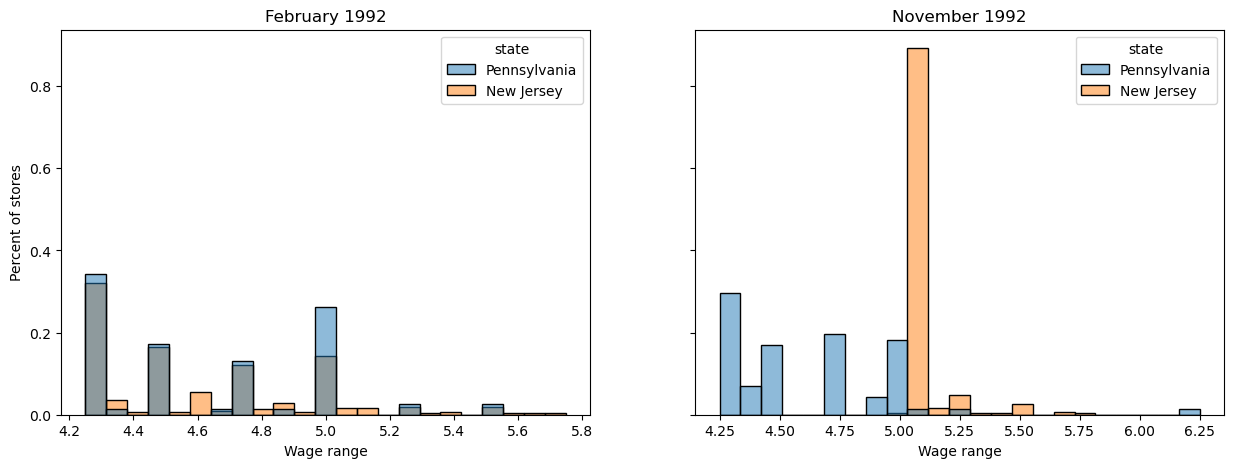

In [16]:
# Plot distribution of the fast food restaurants’ wages grouped 
# by states NJ and PA before and after the treatment

##############################
# Plot distribution of the fast food restaurants’ wages grouped 
# by states NJ and PA before and after the treatment
##############################

feb_data = card_krueger_1994_mod[card_krueger_1994_mod['observation'] == "February 1992"]
nov_data = card_krueger_1994_mod[card_krueger_1994_mod['observation'] == "November 1992"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.histplot(data=feb_data, x='wage_st', hue='state', stat='probability', common_norm=False, bins=23, alpha=0.5, ax=axes[0])
sns.histplot(data=nov_data, x='wage_st', hue='state', stat='probability', common_norm=False, bins=23, alpha=0.5, ax=axes[1])

axes[0].set_title("February 1992")
axes[0].set_xlabel("Wage range")
axes[0].set_ylabel("Percent of stores")

axes[1].set_title("November 1992")
axes[1].set_xlabel("Wage range")

plt.show()

In [17]:
##############################
# Average Treatment Effect
##############################

# four groups with distinct mean values
differences = card_krueger_1994_mod.groupby(['observation', 'state']).agg({"emptot": "mean"}).reset_index()

# Treatment group (NJ) before treatment
njfeb = differences.loc[(differences["observation"] == "February 1992") & (differences["state"] == "New Jersey"), "emptot"].values[0]

# Control group (PA) before treatment
pafeb = differences.loc[(differences["observation"] == "February 1992") & (differences["state"] == "Pennsylvania"), "emptot"].values[0]

# Treatment group (NJ) after treatment
njnov = differences.loc[(differences["observation"] == "November 1992") & (differences["state"] == "New Jersey"), "emptot"].values[0]

# Control group (PA) after treatment
panov = differences.loc[(differences["observation"] == "November 1992") & (differences["state"] == "Pennsylvania"), "emptot"].values[0]

# Two equivalent diff-in-diff
# difference between the difference of November and February within NJ and PA
dif1 = (njnov - njfeb) - (panov - pafeb)

# calculate the difference between the difference of NJ and PA within November and February
dif2 = (njnov - panov) - (njfeb - pafeb)

print(dif1, dif2)

2.753605782980582 2.753605782980582


In [18]:
##############################
# Calculate counterfactual outcome (optional)
##############################


# without the treatment, the employment (emptot) of NJ would decline 
# from February to November by the same amount as PA
nj_counterfactual = pd.DataFrame({"observation": ["February 1992", "November 1992"],
                                   "state": ["New Jersey (Counterfactual)", "New Jersey (Counterfactual)"],
                                   "emptot": [njfeb, njfeb - (pafeb - panov)]})

intervention = pd.DataFrame({
    'observation': ["Intervention", "Intervention", "Intervention"],
    'state': ["New Jersey", "Pennsylvania", "New Jersey (Counterfactual)"],
    'emptot': [19.35, 22.3, 19.35]
})

# Combine data
did_plotdata = pd.concat([differences, nj_counterfactual, intervention], ignore_index=True)

In [20]:
did_plotdata

,observation,state,emptot
0,February 1992,New Jersey,20.439408
1,February 1992,Pennsylvania,23.331169
2,November 1992,New Jersey,21.027429
3,November 1992,Pennsylvania,21.165584
4,February 1992,New Jersey (Counterfactual),20.439408
5,November 1992,New Jersey (Counterfactual),18.273824
6,Intervention,New Jersey,19.350000
7,Intervention,Pennsylvania,22.300000
8,Intervention,New Jersey (Counterfactual),19.350000


<img src="did.png" alt="DiD plot" width="500" height="350">

In [11]:
##############################
# Calculating the DiD estimator by regression
##############################

# create two dummy variables for time & treatment
card_krueger_1994_mod['time'] = np.where(card_krueger_1994_mod['observation'] == "November 1992", 1, 0)
card_krueger_1994_mod['treated'] = np.where(card_krueger_1994_mod['state'] == "New Jersey", 1, 0)

# interaction can be specified with the : operator
X = card_krueger_1994_mod[['time', 'treated']].copy()
X['time_treated'] = X['time'] * X['treated']
X = add_constant(X)

Y = card_krueger_1994_mod['emptot']
idx = np.where(np.isnan(Y))[0]

# drop the missing values
Y1 = Y.dropna()
X1 = X.drop(idx)

did_model = OLS(Y1, X1).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 emptot   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.964
Date:                Sun, 19 Mar 2023   Prob (F-statistic):              0.118
Time:                        01:42:06   Log-Likelihood:                -2904.2
No. Observations:                 794   AIC:                             5816.
Df Residuals:                     790   BIC:                             5835.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.3312      1.072     21.767   

In [12]:
# We may want to only includes fast food restaurants that have responses regarding
# employment (emptot) before and after the treatment 
# (this is a so called balanced sample). 

# we can get this result by computing a fixed effects model 
# which is sometimes also called a within estimator
import statsmodels.api as sm
result = pyreadr.read_r('/Users/mingzhangyin/Dropbox (UFL)/UF teaching/My course/12-Panel data methods- DiD, synthetic control/data/card.rds')
card_krueger_1994_mod = result[None] 
card_krueger_1994_mod = card_krueger_1994_mod[card_krueger_1994_mod['emptot'].notna()]

# Create two dummy variables for time & treatment
card_krueger_1994_mod['time'] = np.where(card_krueger_1994_mod['observation'] == "November 1992", 1, 0)
card_krueger_1994_mod['treated'] = np.where(card_krueger_1994_mod['state'] == "New Jersey", 1, 0)

# Set the DataFrame index as 'sheet' and 'observation'
card_krueger_1994_mod['date'] = pd.to_datetime(card_krueger_1994_mod['observation'])
card_krueger_1994_mod = card_krueger_1994_mod.set_index(['sheet', 'date'])


# Within model (replace column names 'emptot', 'time', and 'treated' if they are different)
did_reg = PanelOLS.from_formula("emptot ~ 1 + time + treated + time:treated + EntityEffects", data=card_krueger_1994_mod, drop_absorbed=True).fit()

print(did_reg)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 emptot   R-squared:                        0.0147
Estimator:                   PanelOLS   R-squared (Between):             -0.0134
No. Observations:                 794   R-squared (Within):               0.0147
Date:                Sun, Mar 19 2023   R-squared (Overall):             -0.0074
Time:                        01:42:06   Log-likelihood                   -2302.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.8495
Entities:                         410   P-value                           0.0591
Avg Obs:                       1.9366   Distribution:                   F(2,382)
Min Obs:                       1.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             2.8495
                            

/var/folders/b6/dnmgz4v90qndj_wtz10vd5rm0000gn/T/ipykernel_83591/1354351693.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_krueger_1994_mod['time'] = np.where(card_krueger_1994_mod['observation'] == "November 1992", 1, 0)
/var/folders/b6/dnmgz4v90qndj_wtz10vd5rm0000gn/T/ipykernel_83591/1354351693.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_krueger_1994_mod['treated'] = np.where(card_krueger_1994_mod['state'] == "New Jersey", 1, 0)
/var/folders/b6/dnmgz4v90qndj_wtz10vd5rm0000gn/T/ipy